<a href="https://colab.research.google.com/github/mbackas/PendulumSims/blob/main/TrippelPenBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install do-mpc
!pip install control

from sympy import *
from sympy.physics.mechanics import *
from sympy.core.numbers import Pi
import numpy as np
from scipy.integrate import solve_ivp
import scipy.fft as FFT

init_vprinting()

from IPython.display import HTML
import control as ct

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 9.8 MB/s eta 0:00:00


In [2]:
#Real Robot
#tdd = I
Irp = 0.000054
Rbp = 0.005
Mbp = 6700*4/3*np.pi*Rbp**3
gp  = 9.8
contactAngle = np.pi/4

# kV=170*2*np.pi/60 #current/torque
kV = 14.9674157 # rad/s/v
Rm = 11.4

print(Mbp*gp*0.095*kV*11.4)
print(0.073/1.014)
print(Mbp)
print(0.1*9.8*0.0035*(250*2*np.pi/60.0)*11.4)

0.5572816950780092
0.07199211045364891
0.0035081117965086034
1.0236879661722342


In [3]:
t = symbols('t')
thetaR, d = dynamicsymbols('θ_R dee')

thetaR_dot = diff(thetaR, t)
d_dot = diff(d, t)

thetaR_dot_dot = diff(thetaR_dot,t)
d_dot_dot = diff(d_dot,t)

Ir, Mb, Rb = symbols('I_r M_b R_b')
g = symbols('g')

torR = symbols('τ_R')
Fb = symbols('F_b')

Ib = 2/5 * Mb * Rb**2

thetaB = d/(sin(contactAngle)*Rbp)
thetaBd = diff(thetaB,t)

xB = d*cos(thetaR) - sin(contactAngle)*Rb*sin(thetaR)
yB = d*sin(thetaR) + sin(contactAngle)*Rb*cos(thetaR)

xBd = diff(xB,t)
yBd = diff(yB,t)

KE1 = 0.5*Ir*thetaR_dot**2
KE2 = 0.5*(Mb*(xBd**2 + yBd**2) + Ib*thetaBd**2)

PE = Mb*g*yB

T = KE1 + KE2
V = PE
# print((T+V).simplify())
L = T - V

# Energy stuff
E1 = KE1
E2 = PE + KE2
Etot = E1 + E2
# maxE = Etot.subs({thetaR:0,thetaR_dot:0, d:0, d_dot:0}).subs(repz)

T1 = diff( diff(L, thetaR_dot), t) - diff(L,thetaR) - torR/kV
T2 = diff( diff(L, d_dot), t) - diff(L,d) - Fb

repz = {Ir:Irp, Mb:Mbp, Rb:Rbp, g:gp}

txtReps = [(thetaR_dot_dot, "θ_Rdd"), (thetaR_dot, "θ_Rd"), (thetaR, "θ_R"),
                (d_dot_dot, "ddd"), (d_dot, "dd"), (d, "d"), (Fb,0)
                ]

# txtReps = [(thetaR.diff(t).diff(t), "theta_1dd"), (thetaR.diff(t), "Theta_1_dot"), (thetaR, "Theta_1"), (torR, "phi_m_1_set"),
#                 (d.diff(t).diff(t), "theta_2dd"), (d.diff(t), "Theta_2_dot"), (d, "Theta_2"), (Fb, "phi_m_2_set"),
#                 (l1,"l1p"),(l2,"l2p"), (m1,"m1p"), (m2,"m2p"),(g,"gp")
#                 ]

# T1 = T1.subs(txtReps)
# T2 = T2.subs(txtReps)
# T = T.subs(txtReps)
# V = V.subs(txtReps)

T1 = simplify(T1)
T2 = simplify(T2)

T1 = T1.cancel()
T2 = T2.cancel()

In [4]:
# solsn = list(nonlinsolve([T1, T2], [thetaRdd, ddd]))

In [5]:
solsp = solve_poly_system([T1, T2], thetaR_dot_dot, d_dot_dot)

In [6]:
# %store solsp

In [7]:
%store -r solsp
thetaRdds = solsp[0][0]
ddds = solsp[0][1]

# thetaRdds = simplify(thetaRdds)
# ddds = simplify(ddds)

thetaRddsym = thetaRdds.cancel()  ## now we have a symbolic expression for the full nonlinear dynamics of the state variables. BOOM!
dddsym = ddds.cancel()

# thetaRddsym = simplify(thetaRddsym)
# dddsym = simplify(dddsym)

thetaRdds = thetaRddsym
ddds = dddsym
# T = simplify(T).cancel()
# V = simplify(V).cancel()

thetaRddtxt = thetaRddsym.subs(txtReps)
dddtxt = dddsym.subs(txtReps)

display(thetaRddtxt)
display(dddtxt)

no stored variable or alias solsp


                   5        5                        5        4                ↪
22627.4169979695⋅Iᵣ ⋅M_b⋅R_b ⋅g⋅sin(θ_R) - 64000.0⋅Iᵣ ⋅M_b⋅R_b ⋅d⋅dd⋅θ_Rd - 32 ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                                                               ↪
                                                                               ↪

↪         5        4                                    5        3       2     ↪
↪ 000.0⋅Iᵣ ⋅M_b⋅R_b ⋅d⋅g⋅cos(θ_R) + 0.707106781186547⋅Iᵣ ⋅M_b⋅R_b ⋅d⋅θ_Rd  + 0 ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                                                                              ↪
↪                                                                              ↪

↪                    5        3                    5        2                  ↪
↪ .707106781186547⋅Iᵣ ⋅M_b⋅R_b ⋅g⋅sin(θ_R) - 4.0⋅Iᵣ ⋅M_b⋅R_b ⋅d⋅dd⋅θ_Rd - 2.0⋅ ↪
↪ ────────────────────────

      2        2       2         2        2                         2          ↪
1.0⋅Iᵣ ⋅M_b⋅R_b ⋅d⋅θ_Rd  - 1.0⋅Iᵣ ⋅M_b⋅R_b ⋅g⋅sin(θ_R) + 3.125e-5⋅Iᵣ ⋅M_b⋅d⋅θ_ ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                                                               ↪
                                                                               ↪

↪   2              2                            2    4       2             2   ↪
↪ Rd  - 3.125e-5⋅Iᵣ ⋅M_b⋅g⋅sin(θ_R) + 1.0⋅Iᵣ⋅M_b ⋅R_b ⋅d⋅θ_Rd  - 0.5⋅Iᵣ⋅M_b ⋅R ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                                                                              ↪
↪                                                                              ↪

↪   4                                     2    3                               ↪
↪ _b ⋅g⋅sin(θ_R) - 1.41421356237309⋅Iᵣ⋅M_b ⋅R_b ⋅d⋅dd⋅θ_Rd - 0.707106781186547 ↪
↪ ────────────────────────

In [8]:
x = Matrix([thetaR, thetaR_dot, d, d_dot])
x_dot = diff(x, t)
Eq(x_dot, Matrix([thetaR_dot, thetaRdds, d_dot, ddds]))

        ⎡                                                                      ↪
        ⎢                                                                      ↪
        ⎢                        5    3                             5          ↪
        ⎢0.707106781186547⋅F_b⋅Iᵣ ⋅R_b  + 2.20970869120796e-5⋅F_b⋅Iᵣ ⋅R_b + 1. ↪
⎡θ_̇R⎤   ⎢───────────────────────────────────────────────────────────────────── ↪
⎢   ⎥   ⎢                                                                      ↪
⎢θ_̈R⎥   ⎢                                                                      ↪
⎢   ⎥ = ⎢                                                                      ↪
⎢dėe⎥   ⎢                                                                      ↪
⎢   ⎥   ⎢                                                                      ↪
⎣dëe⎦   ⎢                                                                      ↪
        ⎢                                                                      ↪
        ⎢               

In [9]:
# thetaRdds = thetaRddsym.subs(repz)
# ddds = dddsym.subs(repz)
# print(thetaRdds)
# thetaRddL = lambdify((thetaR, thetaR_dot, d, d_dot, torR, Fb), thetaRdds,"numpy")
# dddL = lambdify((thetaR, thetaR_dot, d, d_dot, torR, Fb), ddds,"numpy")

# EtotP = Etot.subs(repz)
# EtotL = lambdify((thetaR, thetaR_dot, d, d_dot), EtotP,"numpy")

# print(thetaRddL(0.0*np.pi,0,0.01,0,0,0))
# print(dddL(0*np.pi,0,-0.5,0,0,0))
# # simplify(N(thetaRdd.subs(
# #     {torR:0, Fb:0, thetaR:0,thetaRd:0, d:pi*0.99, dd:0}
# #     )))
# # ddd

In [10]:
def myRev_ODE(t, y):
  return [-y[1],
         -thetaRddL(y[0], y[1], y[2], y[3], 0, 0),
         -y[3],
         -dddL(y[0], y[1], y[2], y[3], 0, 0)
         ]

def my_ODE(t, y):
  ctr = np.dot(K[0],[0,0,0.4,0]-y)
  return [y[1],
         thetaRddL(y[0], y[1], y[2], y[3], ctr, 0),
         y[3],
         dddL(y[0], y[1], y[2], y[3], ctr, 0)
         ]
def my_ODE_obs(t, y):
  ctr = 1*np.dot(K[0],[0,0,0.00,0]-y[4:])
  state = np.array([y[1],
         thetaRddL(y[0], y[1], y[2], y[3], ctr, 0),
         y[3],
         dddL(y[0], y[1], y[2], y[3], ctr, 0),
         ], dtype=float)
  stateH = np.dot(A_obsH,y)
  return np.concatenate((state,stateH),dtype=float)

In [11]:
from IPython.core.display import display, HTML

# create an animation of the pendulum swining with Matplotlib
ballX = lambdify((thetaR,d),xB.subs(repz),"numpy")
ballY = lambdify((thetaR,d),yB.subs(repz),"numpy")
Lr = 0.1 # track length

def ballPos(thtR,dis):
  return ballX(thtR,dis), ballY(thtR,dis)

def trackPos(thtR):
  return Lr*cos(thtR),Lr*sin(thtR)
# create figure

# animate each frame "i"
def animate(i):
    x1o,y1o = trackPos(thetaRo[i])
    x2o,y2o = ballPos(thetaRo[i], do[i])
    line1.set_data([-x1o, x1o], [-y1o, y1o])
    circle1.set_center((x2o, y2o))

def revanimate(i):
    x1o,y1o = trackPos(thetaRo[i])
    x2o,y2o = ballPos(thetaRo[i], do[i])

    line1.set_data([-x1o, x1o], [-y1o, y1o])
    circle1.set_center((x2o, y2o))

    x1o,y1o = trackPos(rthetaRo[-i])
    x2o,y2o = ballPos(rthetaRo[-i], rdo[-i])

    rline1.set_data([-x1o, x1o], [-y1o, y1o])
    rcircle1.set_center((x2o, y2o))

In [12]:
# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

# bonus! Customize color scheme in matplotlib
# change matplotlib defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.titlecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['legend.labelcolor'] = 'white'
# plt.rcParams['xtick.labelcolor'] = 'white'
# plt.rcParams['ytick.labelcolor'] = 'white'
# plt.rcParams['grid.color'] = '#707070'

In [13]:
###Simulate
"""
bTime = 999
bCost = 999
bIC = []
t1ICs = np.arange(0.0,0.15,0.05)
t2ICs = np.arange(-0.15,0.15,0.05)
tICs = []
ICs = bIC
if ICs==[]:
  ICs = [0.01, 0, -0.01, 0]
# y=[thetaR0,thetaRd0, d0, dd0]

if bTime == 999 or bTime == 0:
  bTime = 2

tstop = bTime
fp = float(120)

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 5),
                        layout="constrained")
# ax.grid()
# print(axs)
x1o, y1o = trackPos(ICs[0])
x2o, y2o = ballPos(ICs[0], ICs[2])
# print(len(x1))


# makeAni(sol)
# np.savetxt('pend.csv', np.transpose([to, thetaRo,thetaRdo, do, ddo]), delimiter = ',')
# tICs=[]
print(len(t1ICs)*len(t2ICs))
ICs = []
i = -1
j = -1
t_try = 3
tvals = np.linspace(0,t_try,int(fp*t_try+1))
ino = []

for elem in t1ICs:
  i+=1
  j=-1
  for elem2 in t2ICs:
    j+=1
    tIC = (elem,elem2)
    if(tIC==(0,0)):
      continue
    print(tIC)
    bTime = 999
    bCost= 999
    t1ic = tIC[0]
    t2ic = tIC[1]
    ICs = [0, t1ic, 0, t2ic]

    # outIC = [0.2,0,-0.2,1.308905865] #############################################
    outIC = np.concatenate(([0,0,0.0,0.15],0.001*np.random.randn(4)))
    tm = 5
    cst = 0

    # outIC, tm, cst = simulate(my_ODE, ICs, [t_try,0], tvals[::-1])
    if cst < bCost:
      bCost = cst
      bTime = tm
      bIC = outIC
      startIC = ICs
      print(bIC, cst, tm)
    tstop = bTime
    t_vals = np.linspace(0,tstop,int(fp*tstop+1))
    # bIC = [0.2, 0, 0.2, 0]
    sol = solve_ivp(my_ODE_obs, [0,tstop],bIC,t_eval=t_vals)
    # print("for t",sol.t)
    # print(sol.t[0],sol.t[-1])
    print(sol.y.T[0],sol.y.T[-1])
    ino = np.insert(np.dot(-K[0],sol.y[4:]),0, np.zeros(int(fp)))
    thetaRo =  np.insert(sol.y[0],0,sol.y[0][0]*np.ones(int(fp)))
    thetaRdo = np.insert(sol.y[1],0,sol.y[1][0]*np.ones(int(fp)))
    do =  np.insert(sol.y[2],0,sol.y[2][0]*np.ones(int(fp)))
    ddo = np.insert(sol.y[3],0,sol.y[3][0]*np.ones(int(fp)))
    to=np.insert(sol.t,0,np.zeros(int(fp)))

    #integrate backwareds

    # ICs = [-0.01, 0, -0.01, 0]
    # # ICs = startIC
    # sol = solve_ivp(fun = my_ODE,
    #                 y0 = ICs,
    #                 t_eval = t_vals[::-1],
    #                 t_span = [tstop,0])
    # # print(sol.t[0],sol.t[-1])
    # print(sol.y.T[0],sol.y.T[-1])
    # # print("rev t",sol.t)
    # totE = []
    # # for y in sol.y.T:
    #   # print(y)
    #   # print()
    #   # totE.append(EtotL(y[0],y[1],y[2],y[3]) - maxE)

    # rthetaRo =  np.append(sol.y[0],sol.y[0][-1]*np.ones(int(fp)))
    # rthetaRdo = np.append(sol.y[1],sol.y[1][-1]*np.ones(int(fp)))
    # rdo =  np.append(sol.y[2],sol.y[2][-1]*np.ones(int(fp)))
    # rddo = np.append(sol.y[3],sol.y[3][-1]*np.ones(int(fp)))

    x1o, y1o = trackPos(ICs[0])
    x2o, y2o = ballPos(ICs[0], ICs[2])
    plt.cla()
    # ax = plt.subplot(aspect='equal')
    axs.set_xlim(1.1*-Lr,1.1*Lr)
    axs.set_ylim(1.1*-Lr,1.1*Lr)
    line1, = axs.plot([-x1o, x1o], [-y1o, y1o], lw=5, c='black')
    circle1 = axs.add_patch(plt.Circle((x2o,y2o), Rbp, fc='b', zorder=3))
    circle2 = axs.add_patch(plt.Circle((0,0), 0.5*Rbp, fc='r',zorder=3))
    # print(len(x1))
    # rline1, = axs.plot([-x1o, x1o], [-y1o, y1o], lw=5, c='r')
    # rcircle1 = axs.add_patch(plt.Circle((0,0), Rbp, fc='r', zorder=3))
    makeAni()
    break
  break
    # print("IC DONE",)
print("done",startIC,bIC,bCost,bTime)
"""

'\nbTime = 999\nbCost = 999\nbIC = []\nt1ICs = np.arange(0.0,0.15,0.05)\nt2ICs = np.arange(-0.15,0.15,0.05)\ntICs = []\nICs = bIC\nif ICs==[]:\n  ICs = [0.01, 0, -0.01, 0]\n# y=[thetaR0,thetaRd0, d0, dd0]\n\nif bTime == 999 or bTime == 0:\n  bTime = 2\n\ntstop = bTime\nfp = float(120)\n\nfig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 5),\n                        layout="constrained")\n# ax.grid()\n# print(axs)\nx1o, y1o = trackPos(ICs[0])\nx2o, y2o = ballPos(ICs[0], ICs[2])\n# print(len(x1))\n\n\n# makeAni(sol)\n# np.savetxt(\'pend.csv\', np.transpose([to, thetaRo,thetaRdo, do, ddo]), delimiter = \',\')\n# tICs=[]\nprint(len(t1ICs)*len(t2ICs))\nICs = []\ni = -1\nj = -1\nt_try = 3\ntvals = np.linspace(0,t_try,int(fp*t_try+1))\nino = []\n\nfor elem in t1ICs:\n  i+=1\n  j=-1\n  for elem2 in t2ICs:\n    j+=1\n    tIC = (elem,elem2)\n    if(tIC==(0,0)):\n      continue\n    print(tIC)\n    bTime = 999\n    bCost= 999\n    t1ic = tIC[0]\n    t2ic = tIC[1]\n    ICs = [0, t1ic, 0, t2ic]

In [14]:
"""
slic=400
print(len(to))
plt.plot(to[:-slic],ino[:-slic],'g',lw=2, label=r'torque')
plt.xlabel('Time (seconds)')
plt.ylabel('torque')
# create a plot of theta and theta_dot vs time
plt.figure()
plt.plot(sol.t[:-slic],(sol.y[6]-sol.y[2])[:-slic],label=r'd')
plt.plot(sol.t[:-slic],(sol.y[7]-sol.y[3])[:-slic],label=r'$\dot d$')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$e_d$ (m), $\dot e_d$ (m/s)')
plt.title
plt.figure()
plt.plot(to[:-slic], thetaRo[:-slic], 'r', lw=2, label=r'$\theta$')
plt.plot(to[:-slic], thetaRdo[:-slic], 'b', lw=2, label=r'$\dot \theta$')
# plt.plot(to, totE, 'black', lw=2, label=r'Energy')
plt.title('Simple Pendulum')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\theta$ (deg), $\dot \theta$ (deg/s)')
plt.figure()
comp = np.array([-K[0][0]*sol.y[4],
        -K[0][1]*sol.y[5],
        -K[0][2]*sol.y[6],
        -K[0][3]*sol.y[7],
        np.dot(-K[0],sol.y[4:])
])
for i in range(len(comp[0])):
  maxC = max(abs(comp[:,i]))
  comp[:,i]/=maxC
# comp=np.absolute(comp)
plt.plot(sol.t[0:-slic],comp[0][0:-slic],label=r'$\theta *K_0$')
plt.plot(sol.t[0:-slic],comp[1][0:-slic],label=r'$\dot \theta *K_1$')
plt.plot(sol.t[0:-slic],comp[2][0:-slic],label=r'$d*K_2$')
plt.plot(sol.t[0:-slic],comp[3][0:-slic],label=r'$\dot d*K_3$')
plt.plot(sol.t[0:-slic],comp[4][0:-slic],label='Vm')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\theta$ (deg), $\dot \theta$ (deg/s)')
# plt.grid()
plt.show()
# animate theta, theta_dot vs time
"""

"\nslic=400\nprint(len(to))\nplt.plot(to[:-slic],ino[:-slic],'g',lw=2, label=r'torque')\nplt.xlabel('Time (seconds)')\nplt.ylabel('torque')\n# create a plot of theta and theta_dot vs time\nplt.figure()\nplt.plot(sol.t[:-slic],(sol.y[6]-sol.y[2])[:-slic],label=r'd')\nplt.plot(sol.t[:-slic],(sol.y[7]-sol.y[3])[:-slic],label=r'$\\dot d$')\nplt.legend()\nplt.xlabel('Time (seconds)')\nplt.ylabel(r'$e_d$ (m), $\\dot e_d$ (m/s)')\nplt.title\nplt.figure()\nplt.plot(to[:-slic], thetaRo[:-slic], 'r', lw=2, label=r'$\theta$')\nplt.plot(to[:-slic], thetaRdo[:-slic], 'b', lw=2, label=r'$\\dot \theta$')\n# plt.plot(to, totE, 'black', lw=2, label=r'Energy')\nplt.title('Simple Pendulum')\nplt.legend()\nplt.xlabel('Time (seconds)')\nplt.ylabel(r'$\theta$ (deg), $\\dot \theta$ (deg/s)')\nplt.figure()\ncomp = np.array([-K[0][0]*sol.y[4],\n        -K[0][1]*sol.y[5],\n        -K[0][2]*sol.y[6],\n        -K[0][3]*sol.y[7],\n        np.dot(-K[0],sol.y[4:])\n])\nfor i in range(len(comp[0])):\n  maxC = max(abs

In [15]:
#linearization
def linize(linS, tRdd, disdd, C, Q):
  reps = {thetaR:linS[0], thetaR_dot:linS[1], d:linS[2], d_dot:linS[3], torR:linS[4], Fb:linS[5]}
  # allRep = reps+repz #try to combine the dictionaries

  thetaRddtxt_lin_A = [
  tRdd.diff(thetaR).subs(reps).simplify(),
  tRdd.diff(thetaR_dot).subs(reps).simplify(),
  tRdd.diff(d).subs(reps).simplify(),
  tRdd.diff(d_dot).subs(reps).simplify()]

  thetaRddtxt_lin_B = [tRdd.diff(torR).subs(reps).simplify(),
                       tRdd.diff(Fb).subs(reps).simplify()]

  dddtxt_lin_A = [
  disdd.diff(thetaR).subs(reps).simplify(),
  disdd.diff(thetaR_dot).subs(reps).simplify(),
  disdd.diff(d).subs(reps).simplify(),
  disdd.diff(d_dot).subs(reps).simplify()]

  dddtxt_lin_B = [disdd.diff(torR).subs(reps).simplify(),
                  disdd.diff(Fb).subs(reps).simplify()]

  # print("A=")
  # for item in thetaRddtxt_lin_A:
  #   print(item)
  # print()
  # for item in thetaRddtxt_lin_B:
  #   print(item)
  # print()
  # for item in dddtxt_lin_A:
  #   print(item)
  # print()
  # for item in dddtxt_lin_B:
  #   print(item)
  # print()
  # print(T+V)

  A_lin = np.array([[0,1,0,0],
                    thetaRddtxt_lin_A,
                    [0,0,0,1],
                    dddtxt_lin_A], dtype=float)

  B_lin = np.array([[0],
                    [1*thetaRddtxt_lin_B[0]],
                    [0],
                    [1*dddtxt_lin_B[0]]
                    ], dtype=float)


  vals, vecs = np.linalg.eig(A_lin)
  # K1a[0] = [0.4*2, 0.66*0.1, -5*.25, -5*0.25]
  # ctrPoles = -5*(np.abs(vals)+0.2+abs(0.1*np.random.random(4)))
  # ctrPoles = [-9.97329116e+04, -1.79979505e+00+2.14180296j, -1.79979505e+00-2.14180296j, -1.99945328e+00]

  # K1a, X, ctrPoles = ct.lqr(A_lin, B_lin, Q['x'], Q['u'])
  # K1a = np.array(Q).reshape(1,-1)
  ctrPoles = Q
  K1a = ct.place(A_lin  , B_lin, ctrPoles)
  # K1ad = ct.c2d()
  ctrPoles, ctrVecs = np.linalg.eig(A_lin - B_lin@K1a)
  print("ctrPoles",ctrPoles)

  # obsPoles = -3*np.absolute(ctrPoles)
  obsPoles = [-70, -6,-5.5,-5]
  print("obsPoles",obsPoles)

  L =   ct.place(A_lin.T, C.T  , obsPoles).T

  A_lin_Ox = np.hstack((A_lin, -B_lin@K1a))#, dtype=float)
  A_lin_OxH = np.hstack((L@C, A_lin-L@C-B_lin@K1a))#, dtype=float)
  A_lin_OxHbase = np.hstack((L@C, A_lin-L@C))#, dtype=float)
  A_lin_OxHadd = -B_lin@K1a
  print("base=")
  for row in A_lin_OxHbase:
    for elem in row:
      print(elem,",")
  print()
  print("add=")
  for row in A_lin_OxHadd:
    for elem in row:
      print(elem,",")
  print()
  print("obs=")
  for row in L@C:
    for elem in row:
      print(elem,",",sep='',end='')
    print()
  A_lin_O = np.vstack((A_lin_Ox, A_lin_OxH))#, dtype=float)

  print("A=",A_lin)
  print("B=",B_lin)
  print(A_lin.shape)
  print(B_lin.shape)

  # print("A_obs_L",A_lin_OxH)
  print("L=",L)
  print("obsPoles=",obsPoles)
  print("OLpoles=", vals)

  print("K1=",K1a[0])
  # print("K2=",K1a[1])

  obs = ct.obsv(A_lin, C)
  print(np.linalg.matrix_rank(obs))
  print("CLpoles=",np.linalg.eig(A_lin - B_lin@K1a)[0])
  return K1a, A_lin_OxH
# C = np.array([[1,0,0,0],
#               [0,1,0,0]], dtype=float)
# Qx1 = np.diag([0.1, 5, 3, 5])
# Qu1a = np.diag([0.1, 1])
# Q = {'x':Qx1, 'u':Qu1a}
# K, A_obsH = linize(0,0,0.0,0,thetaRddsym.subs(repz), dddsym.subs(repz), C, Q)

In [16]:
def main(transFuncs, C, physParams, linState, path, Q, applyCtrl):
  repz = {Ir:physParams['Ir'], Mb:physParams['Mb'], Rb:physParams['Rb'], g:physParams['g']}
  thetaRdds = transFuncs[0].subs(repz)
  ddds = transFuncs[1].subs(repz)

  # print(thetaRdds)
  thetaRddL = lambdify((thetaR, thetaR_dot, d, d_dot, torR, Fb), thetaRdds,"numpy")
  dddL = lambdify((thetaR, thetaR_dot, d, d_dot, torR, Fb), ddds,"numpy")
  ##now we have the functions for the nonlinear dynamics!

  calFor=0
  calTor = physParams['Mb']*path[-1][2]*physParams['g']*kV
  # calTor=0
  K, A_obsH = linize(np.concatenate((linState,[calTor,calFor])),thetaRddsym.subs(repz), dddsym.subs(repz), C, Q)
  print("A_obsH=\n",A_obsH)
  ICs = np.concatenate((np.array(path[0]),np.zeros(4)))
  # ICs = [0.2,0,-0.2,1.308905865] #############################################
  # y=[thetaR0,thetaRd0, d0, dd0]
  def the_ODE(t, y):
    ctr = calTor + applyCtrl*np.dot(K[0],path[-1] - y[4:])
    state = np.array([y[1],
          thetaRddL(y[0], y[1], y[2], y[3], ctr, 0),
          y[3],
          dddL(y[0], y[1], y[2], y[3], ctr, 0),
          ], dtype=float)
    stateH = np.dot(A_obsH,y-np.concatenate((linState,linState)))
    return np.concatenate((state,stateH),dtype=float)
  tstop = 5
  fp = float(30)

  fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 5),
                          layout="constrained")
  # ax.grid()

  # np.savetxt('pend.csv', np.transpose([to, thetaRo,thetaRdo, do, ddo]), delimiter = ',')
  t_vals = np.linspace(0,tstop,int(fp*tstop+1))
  sol = solve_ivp(the_ODE, [0,tstop], ICs, t_eval=t_vals)
  ##################################DMD
  X = sol.y
  print(sol.y.shape)
  ####################DMD#########################
  # print("for t",sol.t)
  # print(sol.t[0],sol.t[-1])

  # print(sol.y.T[0],sol.y.T[-1])

  # for a in sol.y[4:].T:
    # a-=path[-1]
  ino = np.insert(np.dot(-K[0],(sol.y[4:])),0, np.zeros(int(fp)))
  thetaRo =  np.insert(sol.y[0],0,sol.y[0][0]*np.ones(int(fp)))
  thetaRdo = np.insert(sol.y[1],0,sol.y[1][0]*np.ones(int(fp)))
  do =  np.insert(sol.y[2],0,sol.y[2][0]*np.ones(int(fp)))
  ddo = np.insert(sol.y[3],0,sol.y[3][0]*np.ones(int(fp)))
  desto = np.insert(sol.y[6],0,sol.y[6][0]*np.ones(int(fp)))
  to=np.insert(sol.t,0,np.zeros(int(fp)))

  x1o, y1o = trackPos(ICs[0])
  x2o, y2o = ballPos(ICs[0], ICs[2])
  x3o, y3o = ballPos(ICs[0], ICs[2])
  # plt.cla()
  # ax = plt.subplot(aspect='equal')

  axs.set_xlim(1.1*-Lr,1.1*Lr)
  axs.set_ylim(1.1*-Lr,1.1*Lr)
  line1, = axs.plot([-x1o, x1o], [-y1o, y1o], lw=2, c='black');
  circle1 = axs.add_patch(plt.Circle((x2o,y2o), Rbp, fc='b', zorder=3));
  circle2 = axs.add_patch(plt.Circle((0,0), 0.5*Rbp, fc='r',zorder=3));
  circle3 = axs.add_patch(plt.Circle((0,0), Rbp*0.9, fc='g',zorder=3));
  # print(len(x1))
  # rline1, = axs.plot([-x1o, x1o], [-y1o, y1o], lw=5, c='r')
  # rcircle1 = axs.add_patch(plt.Circle((0,0), Rbp, fc='r', zorder=3))
  def animate(i):
    x1o,y1o = trackPos(thetaRo[i])
    x2o,y2o = ballPos(thetaRo[i], do[i])
    x3o,y3o = ballPos(thetaRo[i], desto[i])
    line1.set_data([-x1o, x1o], [-y1o, y1o])
    circle1.set_center((x2o, y2o))
    circle3.set_center((x3o, y3o))
  ani = animation.FuncAnimation(fig, animate, frames=len(to), interval = 1000.0/fp)
  # ffmpeg_writer = animation.FFMpegWriter(fps=fp)
  myvid = ani.to_html5_video()
  display(HTML(myvid))
  # print("IC DONE",)
  slic=int(fp)
  print(len(to))
  plt.figure()
  plt.plot(to[:-slic],ino[:-slic],'g',lw=2, label=r'torque')
  plt.xlabel('Time (seconds)')
  plt.ylabel('torque')
  # create a plot of theta and theta_dot vs time
  plt.figure()
  plt.plot(sol.t[:-slic],(sol.y[6]-sol.y[2])[:-slic],label=r'd')
  plt.plot(sol.t[:-slic],(sol.y[7]-sol.y[3])[:-slic],label=r'$\dot d$')
  plt.legend()
  plt.xlabel('Time (seconds)')
  plt.ylabel(r'$e_d$ (m), $\dot e_d$ (m/s)')
  plt.title
  plt.figure()
  plt.plot(to[:-slic], thetaRo[:-slic], 'r', lw=2, label=r'$\theta$')
  plt.plot(to[:-slic], thetaRdo[:-slic], 'b', lw=2, label=r'$\dot \theta$')
  # plt.plot(to, totE, 'black', lw=2, label=r'Energy')
  plt.title('Simple Pendulum')
  plt.legend()
  plt.xlabel('Time (seconds)')
  plt.ylabel(r'$\theta$ (deg), $\dot \theta$ (deg/s)')
  plt.figure()
  comp = -np.array([K[0][0]*sol.y[4],
          K[0][1]*sol.y[5],
          K[0][2]*sol.y[6],
          K[0][3]*sol.y[7],
          np.dot(K[0],sol.y[4:])
  ])
  for i in range(len(comp[0])):
    maxC = max(abs(comp[:,i]))+0.0001
    comp[:,i]/=maxC
  # comp=np.absolute(comp)
  plt.plot(sol.t[0:-slic],comp[0][0:-slic],label=r'$\theta *K_0$')
  plt.plot(sol.t[0:-slic],comp[1][0:-slic],label=r'$\dot \theta *K_1$')
  plt.plot(sol.t[0:-slic],comp[2][0:-slic],label=r'$d*K_2$')
  plt.plot(sol.t[0:-slic],comp[3][0:-slic],label=r'$\dot d*K_3$')
  plt.plot(sol.t[0:-slic],comp[4][0:-slic],label='Vm')
  plt.legend()
  plt.xlabel('Time (seconds)')
  plt.ylabel(r'$\theta$ (deg), $\dot \theta$ (deg/s)')
  # plt.grid()
  plt.show()
  return

ctrPoles [-70. +0.j   -5. +0.j   -2.5+1.6j  -2.5-1.6j]
obsPoles [-70, -6, -5.5, -5]
base=
5.500000139333462 ,
1.0000085278650672 ,
0.0 ,
0.0 ,
-5.500000139333462 ,
-8.527865067220475e-06 ,
0.0 ,
0.0 ,
0.94978492602958 ,
80.99999985825053 ,
0.0 ,
0.0 ,
-0.043866271859890116 ,
-80.99999985825053 ,
-576.5231012101005 ,
0.0 ,
-0.005646403849752691 ,
-1.3856644940622893 ,
0.0 ,
0.0 ,
0.005646403849752691 ,
1.3856644940622893 ,
0.0 ,
1.0 ,
-5.470875480960458 ,
-3.483426255289513 ,
0.0 ,
0.0 ,
0.02821042880369795 ,
3.483426255289513 ,
-1.1323983177121122 ,
0.0 ,

add=
0.0 ,
0.0 ,
0.0 ,
0.0 ,
-735.8283491438549 ,
-80.86972330242104 ,
1142.8802440672468 ,
442.7908163265283 ,
0.0 ,
0.0 ,
0.0 ,
0.0 ,
-1.445303376302562 ,
-0.15884313816617135 ,
2.244828807400241 ,
0.8697233024211534 ,

obs=
5.500000139333462,1.0000085278650672,0.0,0.0,
0.94978492602958,80.99999985825053,0.0,0.0,
-0.005646403849752691,-1.3856644940622893,0.0,0.0,
-5.470875480960458,-3.483426255289513,0.0,0.0,
A= [[ 0.000  1.000  0.

181


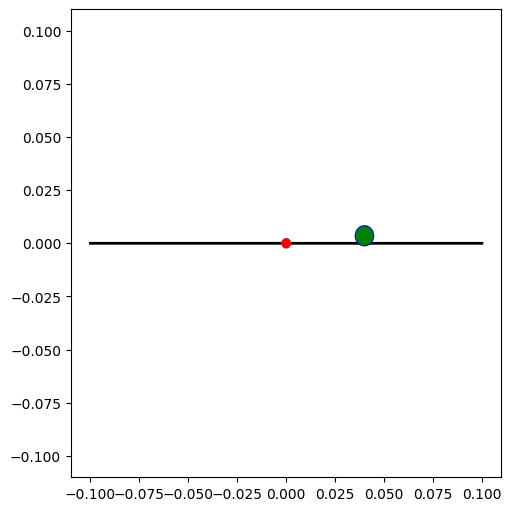

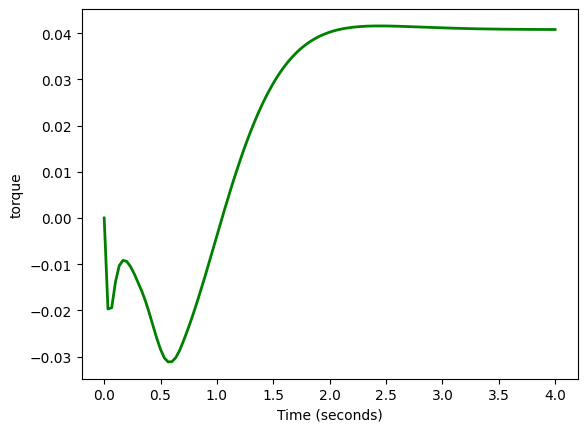

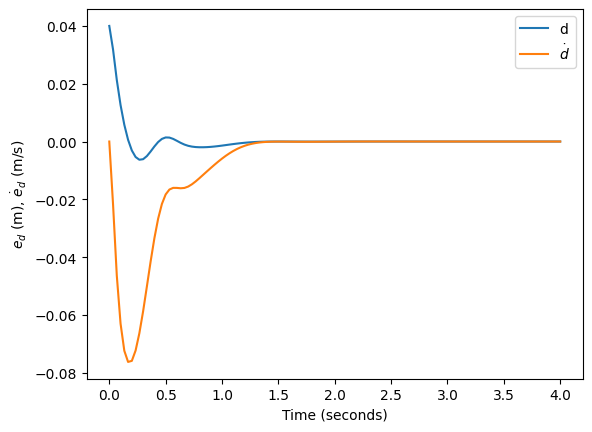

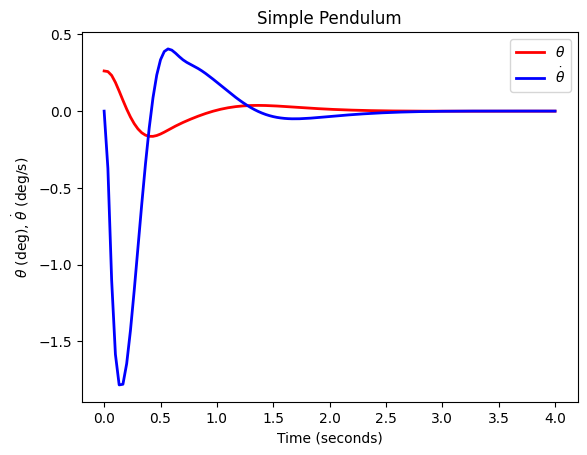

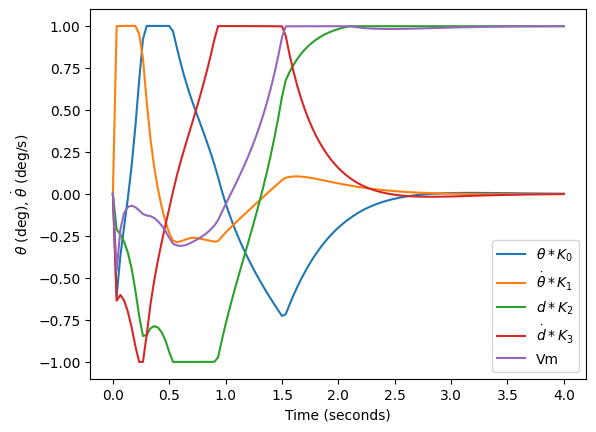

In [17]:
# Irp = 14948e-9
# Irp = 56648e-9 + 1521e-9 # g*mm^2 g*1kg/1000g * 1m^2/ 1000^2 mm^2 -> e-9
Irp = 0.000054
Rbp = 0.005
Mbp = 1*6700*4/3*np.pi*Rbp**3
gp  = 9.8
params = {'Ir':Irp, 'Mb':Mbp, 'g':gp, 'Rb':Rbp}
C = np.array([[1,0,0,0],
              [0,1,0,0]], dtype=float)
applyCtrl = 1
# Qx1 = np.diag([0.1, 5, 20, 5])
Qx1 = np.diag([1, 1, 1, 1])
Qu1a = np.diag([2])
# Q = {'x':Qx1, 'u':Qu1a}
Q = np.array([-70, -5, -2.5+1.6j,  -2.5-1.6j])
# Q=[0.300,  0.056, 1.1*-0.634, -0.127]
path = [[np.pi/12,0,-0.04,0.0],
        [0.0,0.0, 0.04,0.0]]

linS = path[-1]
# linS = [0,0,0,0]

main([thetaRddsym, dddsym], C, params, linS, path, Q, applyCtrl)

In [18]:
#SVD
SVD_frames = np.array([frame.flatten() for frame in sol.y])
U, S, VT = np.linalg.svd(SVD_frames,full_matrices=False)
S = np.diag(S)

NameError: name 'sol' is not defined

In [19]:
r=100
denoised_video_SVD = U[:,:r] @ S[0:r,0:r] @ VT[:r,:]
denoised_frames_SVD = [
    cv2.normalize(frame.reshape(720,1280), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    for frame in denoised_video_SVD
]

gif_path = "SVD.mp4"
imageio.mimsave(gif_path, [np.vstack((SVDframe,Noiseframe)) for SVDframe,Noiseframe in zip(denoised_frames_SVD,original_frames)], duration=1/24)  # Set duration to match 24 FPS

# Display the GIF in a Jupyter Notebook or compatible environment
display(Image(filename=gif_path))

NameError: name 'U' is not defined

In [ ]:
# video array code:
# ffmpeg \
# -i m1.mp4 -i m2.mp4 -i m3.mp4 -i m4.mp4 \
# -filter_complex \
# "[0:v][1:v]hstack=inputs=2[top]; \
# [2:v][3:v]hstack=inputs=2[bottom]; \
# [top][bottom]vstack=inputs=2[v]" \
# -map "[v]" \
# finalOutput.mp4

In [ ]:
import csv
import matplotlib.pyplot as plt
import scipy.fft as FFT
import numpy as np
from numpy.polynomial import polynomial as P

tims = []
tors = []
angs = []
with open('/content/drive/MyDrive/Colab Notebooks/TrackenSysIDPulse.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  row_count=0
  for row in csv_reader:
    if(row_count>0):
      tims.append(float(row[0])/1000.0)
      tors.append(float(row[1])/(kV*100.0))
    # if (row_count>4000): tors.append(1.0)
    # else: tors.append(0)
    # print(row[0],row[3])
      angs.append(float(row[3]))
    row_count+=1
print(row_count)
middle = int(row_count/2)+1
print(middle)
print(tors[5])
fftTor = FFT.fftshift(FFT.fft(tors))[middle:middle+30]
fftAng = FFT.fftshift(FFT.fft(angs))[middle:middle+30]
transfer = fftTor/fftAng
freqs = 2*np.pi*FFT.fftshift(FFT.fftfreq(row_count-1,10.0/row_count))[middle:middle+30]
c,stats = P.polyfit(freqs,abs(transfer),1,full=True)
print(c)
# print(stats)
yfit = P.polyval(freqs,c[::1])
cLin,stats = P.polyfit(tims[:200],angs[:200],1,full=True)
print(cLin)
yfitLin = P.polyval(tims[:200],cLin[::1])
# print(yfit)
# print(yfitLin)
# print(freqs[2])
plt.figure()
plt.title('TimePlots')
plt.plot(tims[:200],tors[:200])
plt.plot(tims[:200],angs[:200])
plt.plot(tims[:200],yfitLin)
plt.figure()
plt.title('transfer Function Gain')
plt.plot(freqs,np.abs(transfer))
plt.plot(freqs,yfit)
plt.figure()
plt.title('transfer Function Phase')
plt.plot(freqs,np.angle(transfer))
plt.figure()
plt.title('abs(FFT Torque)')
plt.plot(freqs,np.abs(fftTor))
# plt.plot(freqs[middle:middle+100],np.abs(fftAng))
plt.figure()
plt.title('angle(FFT Torque)')
plt.plot(freqs,np.angle(fftTor))
# plt.plot(freqs[middle:middle+100],np.angle(fftAng))
# print(angs)

print(tors[5]/cLin[1])

In [ ]:
# thetaRdd =
# a   -g*l1*l2(2*m1+m2)        sin(θ1)
# b   -g*l1*l2*m2*             sin(θ1 - 2*θ2)
# c   -l1**2*l2*m2*            θ1d**2*sin(2*(θ1 - θ2))
# d   -2*l1*l2**2*m2           θ2d**2*sin(θ1 - θ2)
# e   -2*l1                    tau2*cos(θ1 - θ2)
# f   +2*l2                    tau1

#  /

# g   +2*l1**2*l2*(m1+m2)
# h   -2*l1**2*l2*m2            cos(θ1 - θ2)**2





# ddd =
# i   -g*l1*l2*m2(m1+m2)      sin(θ2)
# j   +g*l1*l2*m2(m1+m2)      sin(2*θ1 - θ2)
# k   +2*l1**2*l2*m2(m1+m2)   θ1d**2*sin(θ1 - θ2)
# l   +l1*l2**2*m2**2         θ2d**2*sin(2*(θ1 - θ2))
# m   +2*l1*(m1+m2)           tau2
# n   -2*l2*m2*               tau1*cos(θ1 - θ2)

#   /

# o   +2*l1*l2**2*m2(m1+m2)
# p   -2*l1*l2**2*m2**2      cos(θ1 - θ2)**2

In [ ]:
# X=[thetaR, thetaR_dot, d, d_dot, torR, Fb]
# def A(x):
#   return sin(x[0])

# def B(x):
#   return sin(x[0] - 2*x[2])

# def C(x):
#   return x[1]**2 * sin(2*(x[0] - x[2]))

# def D(x):
#   return x[3]**2 * sin(x[0] - x[2])

# def E(x):
#   return x[5]*cos(x[0] - x[2])

# def F(x):
#   return x[4]

# def G(x):
#   return 1

# def H(x):
#   return cos(x[0] - x[2])**2



# a  = -g*l1*l2*(2*m1 + m2)
# b  = -g*l1*l2*m2
# c  = -l1**2*l2*m2
# d  = -2*l1*l2**2*m2
# e  = -2*l1
# f  =  2*l2


# g =  2*l1**2*l2*(m1 + m2)
# h = -2*l1**2*l2*m2



# def J(x):
#   return sin(x[2])

# def K(x):
#   return sin(2*x[0] - x[2])

# def L(x):
#   return x[1]**2*sin(x[0] - x[2])

# def M(x):
#   return x[3]**2*sin(2*(x[0] - x[2]))

# def N(x):
#   return x[5]

# def O(x):
#   return x[4]*cos(x[0] - x[2])

# def P(x):
#   return 1

# def Q(x):
#   return cos(x[0] - x[2])**2

# # ddd =
# j = -g*l1*l2*m2*(m1+m2)      #sin(θ2)
# k = +g*l1*l2*m2*(m1+m2)      #sin(2*θ1 - θ2)
# l = +2*l1**2*l2*m2*(m1+m2)   #θ1d**2*sin(θ1 - θ2)
# m = +l1*l2**2*m2**2          #θ2d**2*sin(2*(θ1 - θ2))
# n = +2*l1*(m1+m2)            #tau2
# o = -2*l2*m2                 #tau1*cos(θ1 - θ2)

# #   /

# p = +2*l1*l2**2*m2*(m1 + m2)
# q = -2*l1*l2**2*m2**2       #cos(θ1 - θ2)**2

In [ ]:
# X_nonlin1 = [A(X), B(X), C(X), D(X), E(X), F(X), G(X), H(X)]
# coeffs1 = [a,b,c,d,e,f,g,h]

# num1 = np.dot(coeffs1[:6], X_nonlin1[:6])
# denom1 = np.dot(coeffs1[6:],X_nonlin1[6:])
# display(num1/denom1)

# X_nonlin2 = [J(X), K(X), L(X), M(X), N(X), O(X), P(X), Q(X)]
# coeffs2 = [j,k,l,m,n,o,p,q]

# num2 = np.dot(coeffs2[:6], X_nonlin2[:6])
# denom2 = np.dot(coeffs2[6:],X_nonlin2[6:])
# print()
# display(num2/denom2)

In [ ]:

# a = thetaRddsym.coeff()
# display(a)
print(thetaRddsym)
# print((a*f_a(X) + b*f_b(X) + c*f_c(X) + d*f_d(X) + e*f_e(X) + f*f_f(X)) / (g*f_g(X) + h*f_h(X)) )

In [ ]:
# thetaRdds = solve(T1, thetaRdd)[0]
# T2 = T2.subs({thetaRdd:thetaRdds})

# ddds = solve(T2,ddd)[0]
# thetaRdds = thetaRdds.subs({ddd:ddds})

In [ ]:
import do_mpc
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

phi_1 = model.set_variable(var_type='_x', var_name='phi_1', shape=(1,1))
phi_2 = model.set_variable(var_type='_x', var_name='phi_2', shape=(1,1))
phi_3 = model.set_variable(var_type='_x', var_name='phi_3', shape=(1,1))
phi_4 = model.set_variable(var_type='_x', var_name='phi_4', shape=(1,1))

# Variables can also be vectors:
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(4,1))
# Two states for the desired (set) motor position:
phi_m_1_set = model.set_variable(var_type='_u', var_name='phi_m_1_set')
phi_m_2_set = model.set_variable(var_type='_u', var_name='phi_m_2_set')

# print('dphi={}, with dphi.shape={}'.format(dphi, dphi.shape))

Theta_1 = model.set_variable('parameter', 'Theta_1')
Theta_1_dot = model.set_variable('parameter', 'Theta_1_dot')
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_2_dot = model.set_variable('parameter', 'Theta_2_dot')

model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])
model.set_rhs('phi_4', dphi[3])

from casadi import *

dphi_next = vertcat(
    dphi[1],
    (-Theta_1_dot**2*l1p**2*l2p*m2p*sin(2*Theta_1 - 2*Theta_2) - 2*Theta_2_dot**2*l1p*l2p**2*m2p*sin(Theta_1 - Theta_2) - 2*gp*l1p*l2p*m1p*sin(Theta_1) - gp*l1p*l2p*m2p*sin(Theta_1) - gp*l1p*l2p*m2p*sin(Theta_1 - 2*Theta_2) - 2*l1p*phi_m_2_set*cos(Theta_1 - Theta_2) + 2*l2p*phi_m_1_set)/(2*l1p**2*l2p*m1p - 2*l1p**2*l2p*m2p*cos(Theta_1 - Theta_2)**2 + 2*l1p**2*l2p*m2p),
    dphi[3],
     (2*Theta_1_dot**2*l1p**2*l2p*m1p*m2p*sin(Theta_1 - Theta_2) + 2*Theta_1_dot**2*l1p**2*l2p*m2p**2*sin(Theta_1 - Theta_2) + Theta_2_dot**2*l1p*l2p**2*m2p**2*sin(2*Theta_1 - 2*Theta_2) - gp*l1p*l2p*m1p*m2p*sin(Theta_2) + gp*l1p*l2p*m1p*m2p*sin(2*Theta_1 - Theta_2) - gp*l1p*l2p*m2p**2*sin(Theta_2) + gp*l1p*l2p*m2p**2*sin(2*Theta_1 - Theta_2) + 2*l1p*m1p*phi_m_2_set + 2*l1p*m2p*phi_m_2_set - 2*l2p*m2p*phi_m_1_set*cos(Theta_1 - Theta_2))/(2*l1p*l2p**2*m1p*m2p - 2*l1p*l2p**2*m2p**2*cos(Theta_1 - Theta_2)**2 + 2*l1p*l2p**2*m2p**2)
)

model.set_rhs('dphi', dphi_next)

model.setup()


In [ ]:
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

mterm = (phi_1)**2 + phi_2**2 + (phi_3)**2 + phi_4**2
lterm = (phi_1)**2 + phi_2**2 + (phi_3)**2 + phi_4**2

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(
    phi_m_1_set=1e-2,
    phi_m_2_set=1e-2
)

# Lower bounds on states:
mpc.bounds['lower','_x', 'phi_1'] = -2*np.pi
mpc.bounds['lower','_x', 'phi_2'] = -2*np.pi
mpc.bounds['lower','_x', 'phi_3'] = -2*np.pi
mpc.bounds['lower','_x', 'phi_4'] = -2*np.pi
# Upper bounds on states
mpc.bounds['upper','_x', 'phi_1'] = 2*np.pi
mpc.bounds['upper','_x', 'phi_2'] = 2*np.pi
mpc.bounds['upper','_x', 'phi_3'] = 2*np.pi
mpc.bounds['upper','_x', 'phi_4'] = 2*np.pi

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'phi_m_1_set'] = -2*np.pi
mpc.bounds['lower','_u', 'phi_m_2_set'] = -2*np.pi
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'phi_m_1_set'] = 2*np.pi
mpc.bounds['upper','_u', 'phi_m_2_set'] = 2*np.pi

mpc.set_uncertainty_values(
    Theta_1 = [1],
    Theta_1_dot = [1],
    Theta_2 = [1],
    Theta_2_dot = [1]
)

mpc.setup()

In [ ]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)
p_template = simulator.get_p_template()
type(p_template)
p_template.keys()

def p_fun(t_now):
    p_template['Theta_1'] = 2.25e-4
    p_template['Theta_1_dot'] = 2.25e-4
    p_template['Theta_2'] = 2.25e-4
    p_template['Theta_2_dot'] = 2.25e-4
    return p_template

simulator.set_p_fun(p_fun)
simulator.setup()
x0 = np.pi*np.array([np.pi, 0, np.pi, 0, 0, 0, 0, 0]).reshape(-1,1)

simulator.x0 = x0
mpc.x0 = x0

mpc.set_initial_guess()


In [ ]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()
u0 = np.zeros((2,1))
for i in range(500):
    # u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

# %%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='phi_1', axis=ax[0])
    g.add_line(var_type='_x', var_name='phi_2', axis=ax[0])
    g.add_line(var_type='_x', var_name='phi_3', axis=ax[0])
    g.add_line(var_type='_x', var_name='phi_4', axis=ax[0])


    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='phi_m_1_set', axis=ax[1])
    g.add_line(var_type='_u', var_name='phi_m_2_set', axis=ax[1])


ax[0].set_ylabel('angle position [rad]')
ax[1].set_ylabel('motor angle [rad]')
ax[1].set_xlabel('time [s]')

sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:

θ1dd=
*   a * sin(θ1)
*   b * sin(θ1-2θ2)
*   c * sin(2(θ1-θ2))*(θ1d)^2
*   d * sin(θ1-θ2)*(θ2d)^2
*   e * τ2 * cos(θ1−θ2)
*   f * τ1

all over

g - h*sin^2(θ1-θ2)

θ2dd=
* i * sin(θ2)
* j * sin(2θ1-θ2)
* k * sin(θ1-θ2)(θ1d)^2
* l * sin(2(θ1-θ2))(θ2d)^2
* m * τ2
* n * τ1*cos(θ1-θ2)

all over

* o - p*sin^2(θ1-θ2)

(6+2)*2 coeffs = 16

l1,l2,m1,m2,g are the unknowns = 5

11 terms are redundant

a =9

In [ ]:
#Energy Gradients!
torR1_grad = diff(E1,thetaR_dot)
torR2_grad = diff(E1, d_dot)
Fb1_grad = diff(E2, thetaR_dot)
Fb2_grad = diff(E2, d_dot)

torR_grad = diff(Etot, thetaR_dot)
Fb_grad = diff(Etot, d_dot)

torR_grad = torR_grad.subs(txtReps)
Fb_grad = Fb_grad.subs(txtReps)

torR1_grad = torR1_grad.subs(txtReps)
torR2_grad = torR2_grad.subs(txtReps)
Fb1_grad = Fb1_grad.subs(txtReps)
Fb2_grad = Fb2_grad.subs(txtReps)

# print(torR1_grad.simplify())
# print(torR2_grad.simplify())
# print(Fb1_grad.simplify())
# print(Fb2_grad.simplify())

# print(torR_grad.simplify())
# print(Fb_grad.simplify())

# print(E1.subs(txtReps).simplify())
# print(E2.subs(txtReps).simplify())

In [ ]:
def simulate(ODE, IC, tsim, tvals):
  sol = solve_ivp(fun = ODE, t_span = tsim, y0=IC, t_eval = tvals)
  if(sol.t[0]>0):
    sol.t=sol.t[::-1]
  totE = []

  for y in sol.y.T:
    totE.append(EtotL(y[0],y[1],y[2],y[3])-maxE)

  bestCost = 999
  bestTime = 999
  for i in range(len(sol.y.T)):
    # print(sol.t[i])
    if(sol.y.T[i][0] > np.pi): sol.y.T[i][0]-=2*np.pi
    elif(sol.y.T[i][0] < -np.pi): sol.y.T[i][0]+=2*np.pi
    if(sol.y.T[i][2] > np.pi): sol.y.T[i][2]-=2*np.pi
    elif( sol.y.T[i][2] < -np.pi): sol.y.T[i][2]+=2*np.pi
    cost = sol.y.T[i][0]**2 + sol.y.T[i][2]**2
    if cost < 0.1:
      return sol.y.T[i], sol.t[i], cost
    if cost < bestCost:
      bestCost = cost
      bestTime = sol.t[i]
      IC = sol.y.T[i]
    # print(sol.t[i],sol.y.T[i],cost)
  return IC, bestTime, bestCost

In [ ]:
Torque exerted by ball = torque = m*g*x = V*kT
kT = 260rpm/V * 2pi rad/rev *60s/1min

In [ ]:
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show


#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 1000.0
nsamples = 400


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 2.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
print(np.array2string(taps,separator=","))
print(np.array2string(np.zeros(len(taps)),separator=","))
print(len(taps))

In [ ]:
# Install necessary libraries with pyav support for imageio
%pip install imageio[pyav] opencv-python-headless scikit-image moviepy matplotlib

import cv2
import numpy as np
from skimage.restoration import denoise_tv_chambolle
import imageio.v3 as iio
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
from IPython.display import Image
import imageio

# Function to add salt and pepper noise to an image
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = image.copy()
    # Add salt noise (set some pixels to 255)
    num_salt = int(np.ceil(salt_prob * image.size))
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise (set some pixels to 0)
    num_pepper = int(np.ceil(pepper_prob * image.size))
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Step 1: Load a sample video from imageio (using the pyav plugin)
input_video_path = 'imageio:cockatoo.mp4'
video = iio.imread(input_video_path, plugin="pyav")  # Load video frames as numpy array

# Convert video frames to grayscale and add salt-and-pepper noise
original_frames = []
for frame in video:
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    noisy_frame = add_salt_and_pepper_noise(gray_frame)
    original_frames.append(noisy_frame)

# Convert frames to a 3D numpy array for denoising
video_array = np.stack(original_frames, axis=0)

In [ ]:
# Step 2: Apply 3D Total Variation Denoising
weight = 0.1  # Adjust as needed based on desired smoothness
denoised_video_array = denoise_tv_chambolle(video_array, weight=weight)

# Convert denoised frames back to list format and normalize pixel values
denoised_frames = [
    cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    for frame in denoised_video_array
]


# Step 3: Compute and plot noise statistics
# Flatten pixel values for all frames in original and denoised videos
original_pixels = np.concatenate([frame.flatten() for frame in original_frames])
denoised_pixels = np.concatenate([frame.flatten() for frame in denoised_frames])

# Plot histograms of pixel intensities
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(original_pixels, bins=50, color='blue', alpha=0.7, label='Original (Noisy)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution - Original (with Noise)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(denoised_pixels, bins=50, color='green', alpha=0.7, label='Denoised')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution - Denoised')
plt.legend()

plt.tight_layout()
plt.show()

# Step 4: Create side-by-side frames for the GIF
side_by_side_frames = []
for original, denoised in zip(original_frames, denoised_frames):
    # Stack original and denoised frames horizontally
    side_by_side = np.hstack((original, denoised))
    side_by_side_frames.append(side_by_side)

# Step 5: Save the side-by-side frames as a GIF
gif_path = "side_by_side_denoised.gif"
imageio.mimsave(gif_path, side_by_side_frames, duration=1/24)  # Set duration to match 24 FPS

# Display the GIF in a Jupyter Notebook or compatible environment
display(Image(filename=gif_path))

In [ ]:
#SVD
SVD_frames = np.array([frame.flatten() for frame in original_frames])
U, S, VT = np.linalg.svd(SVD_frames,full_matrices=False)
S = np.diag(S)


In [ ]:
r=100
denoised_video_SVD = U[:,:r] @ S[0:r,0:r] @ VT[:r,:]
denoised_frames_SVD = [
    cv2.normalize(frame.reshape(720,1280), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    for frame in denoised_video_SVD
]

gif_path = "SVD.mp4"
imageio.mimsave(gif_path, [np.vstack((SVDframe,Noiseframe)) for SVDframe,Noiseframe in zip(denoised_frames_SVD,original_frames)], duration=1/24)  # Set duration to match 24 FPS

# Display the GIF in a Jupyter Notebook or compatible environment
display(Image(filename=gif_path))